In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# 1. Load CIFAR-100 data
(X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')

# 2. One-hot encode the labels
enc = OneHotEncoder(sparse_output=False)
y_train = enc.fit_transform(y_train)
y_test = enc.transform(y_test)

# 3. Define preprocessing function (resize + normalize)
def preprocess(image, label):
    # image = tf.image.resize(image, [128, 128])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# 4. Shuffle training data before splitting
train_indices = np.arange(len(X_train))
np.random.shuffle(train_indices)

X_train = X_train[train_indices]
y_train = y_train[train_indices]

# 5. Compute split sizes
val_size = int(0.1 * len(X_train))
X_val = X_train[:val_size]
y_val = y_train[:val_size]
X_train = X_train[val_size:]
y_train = y_train[val_size:]

# 6. Create tf.data.Dataset pipelines
batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)


#### 6 CNN Model 

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

def cnn_model_6():
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 2
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Block 3
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Classifier
    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='softmax'))  

    return model




In [3]:
# Instantiate and compile
model6 = cnn_model_6()
model6.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model6.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

In [4]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model6.fit(train_dataset,
    batch_size=64,
    epochs=100,
    validation_data=val_dataset,
    shuffle=True,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
704/704 [==============================] - 35s 12ms/step - loss: 3.9768 - accuracy: 0.1079 - val_loss: 3.5141 - val_accuracy: 0.1730
Epoch 2/100
704/704 [==============================] - 8s 11ms/step - loss: 3.1550 - accuracy: 0.2268 - val_loss: 2.8853 - val_accuracy: 0.2864
Epoch 3/100
704/704 [==============================] - 7s 9ms/step - loss: 2.7248 - accuracy: 0.3036 - val_loss: 2.5818 - val_accuracy: 0.3442
Epoch 4/100
704/704 [==============================] - 7s 9ms/step - loss: 2.4825 - accuracy: 0.3541 - val_loss: 2.3805 - val_accuracy: 0.3926
Epoch 5/100
704/704 [==============================] - 7s 9ms/step - loss: 2.3245 - accuracy: 0.3869 - val_loss: 2.1828 - val_accuracy: 0.4298
Epoch 6/100
704/704 [==============================] - 7s 10ms/step - loss: 2.1898 - accuracy: 0.4131 - val_loss: 2.1486 - val_accuracy: 0.4244
Epoch 7/100
704/704 [==============================] - 7s 10ms/step - loss: 2.0991 - accuracy: 0.4337 - val_loss: 2.1217 - val_accuracy: 0

In [6]:
test_loss, test_accuracy = model6.evaluate(test_dataset, verbose=1)
print(f'Test accuracy: {test_accuracy:.4f}')


157/157 [==============================] - 1s 7ms/step - loss: 1.5643 - accuracy: 0.5677
Test accuracy: 0.5677


### 7 CNN

In [17]:
def cnn_model_7():
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 2
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Block 3
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # ✅ Block 4 - New convolutional block (7th convolutional layer)
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    # Classifier
    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='softmax'))  # CIFAR-100 has 100 classes

    return model

In [18]:
# Instantiate and compile
model7 = cnn_model_7()
model7.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model7.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_23 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_23 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_24 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_24 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)       

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model7.fit(train_dataset,
    batch_size=64,
    epochs=100,
    validation_data=val_dataset,
    shuffle=True,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
704/704 [==============================] - 11s 13ms/step - loss: 4.2702 - accuracy: 0.0595 - val_loss: 3.8811 - val_accuracy: 0.0976
Epoch 2/100
704/704 [==============================] - 8s 11ms/step - loss: 3.5628 - accuracy: 0.1456 - val_loss: 3.4396 - val_accuracy: 0.1808
Epoch 3/100
704/704 [==============================] - 8s 11ms/step - loss: 3.1186 - accuracy: 0.2192 - val_loss: 2.9633 - val_accuracy: 0.2632
Epoch 4/100
704/704 [==============================] - 8s 11ms/step - loss: 2.8268 - accuracy: 0.2734 - val_loss: 3.2649 - val_accuracy: 0.2176
Epoch 5/100
704/704 [==============================] - 8s 11ms/step - loss: 2.6217 - accuracy: 0.3134 - val_loss: 2.8200 - val_accuracy: 0.2784
Epoch 6/100
704/704 [==============================] - 8s 11ms/step - loss: 2.4592 - accuracy: 0.3514 - val_loss: 2.4391 - val_accuracy: 0.3644
Epoch 7/100
704/704 [==============================] - 8s 12ms/step - loss: 2.3420 - accuracy: 0.3736 - val_loss: 2.3156 - val_accuracy

In [20]:
test_loss, test_accuracy = model7.evaluate(test_dataset, verbose=1)
print(f'Test accuracy: {test_accuracy:.4f}')

157/157 [==============================] - 1s 4ms/step - loss: 1.5347 - accuracy: 0.5769
Test accuracy: 0.5769


#### 8 CNN

In [26]:
def cnn_model_8():
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 2
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Block 3 (new block — adds 2 convs)
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Block 4 (new block — adds 2 convs = now total 8 conv layers)
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))  # No pooling here to keep some spatial size

    # Classifier
    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='softmax'))  # CIFAR-100

    return model


In [27]:
# Instantiate and compile
model8 = cnn_model_8()
model8.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model8.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_41 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_41 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_42 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_42 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 32)       

In [ ]:
# Get the first Conv2D layer
first_conv_layer = model8.layers[0]

# Save a copy of the filters before training
filters_before = first_conv_layer.get_weights()[0].copy()  

In [29]:
filters_before.shape

(3, 3, 3, 32)

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model8.fit(train_dataset,
    batch_size=64,
    epochs=100,
    validation_data=val_dataset,
    shuffle=True,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
704/704 [==============================] - 10s 12ms/step - loss: 4.1208 - accuracy: 0.0830 - val_loss: 3.6825 - val_accuracy: 0.1226
Epoch 2/100
704/704 [==============================] - 8s 11ms/step - loss: 3.3704 - accuracy: 0.1841 - val_loss: 3.1364 - val_accuracy: 0.2262
Epoch 3/100
704/704 [==============================] - 8s 11ms/step - loss: 2.9496 - accuracy: 0.2562 - val_loss: 2.9219 - val_accuracy: 0.2616
Epoch 4/100
704/704 [==============================] - 8s 11ms/step - loss: 2.6665 - accuracy: 0.3104 - val_loss: 2.6168 - val_accuracy: 0.3352
Epoch 5/100
704/704 [==============================] - 7s 10ms/step - loss: 2.4599 - accuracy: 0.3545 - val_loss: 2.7115 - val_accuracy: 0.3168
Epoch 6/100
704/704 [==============================] - 8s 11ms/step - loss: 2.3098 - accuracy: 0.3875 - val_loss: 2.3622 - val_accuracy: 0.3946
Epoch 7/100
704/704 [==============================] - 7s 10ms/step - loss: 2.1852 - accuracy: 0.4105 - val_loss: 2.2969 - val_accuracy

In [31]:
filters_after = first_conv_layer.get_weights()[0]  # Shape: (3, 3, 3, 32)

filters_after.shape

(3, 3, 3, 32)

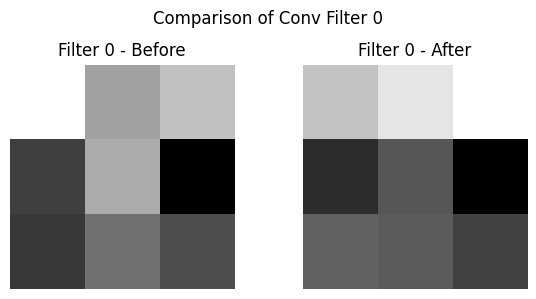

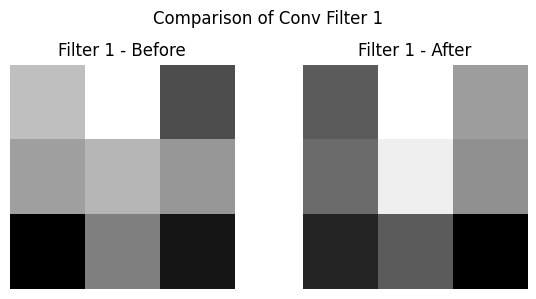

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_filter_change(before, after, filter_index=0):
    # Take one 3x3x3 filter and average over the RGB channels to make it 2D
    filter_before = np.mean(before[:, :, :, filter_index], axis=2)
    filter_after = np.mean(after[:, :, :, filter_index], axis=2)

    plt.figure(figsize=(6, 3))

    # Before Training
    plt.subplot(1, 2, 1)
    plt.imshow(filter_before, cmap='gray')
    plt.title(f'Filter {filter_index} - Before')
    plt.axis('off')

    # After Training
    plt.subplot(1, 2, 2)
    plt.imshow(filter_after, cmap='gray')
    plt.title(f'Filter {filter_index} - After')
    plt.axis('off')

    plt.suptitle(f'Comparison of Conv Filter {filter_index}')
    plt.tight_layout()
    plt.show()

# Try it for a couple of filters
visualize_filter_change(filters_before, filters_after, filter_index=0)
visualize_filter_change(filters_before, filters_after, filter_index=1)


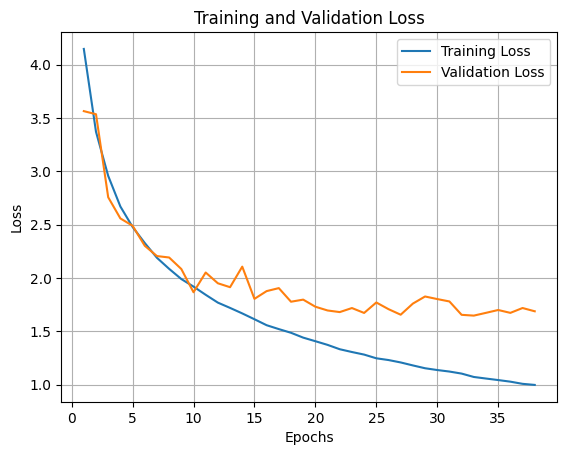

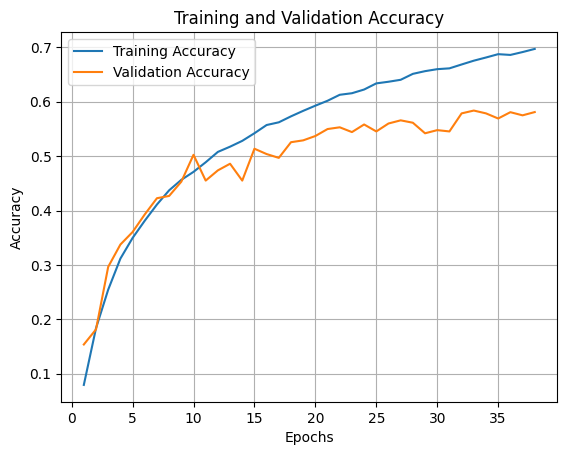

In [25]:
import matplotlib.pyplot as plt

# Extract data from training history
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot Loss
plt.figure()
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure()
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
test_loss, test_accuracy = model8.evaluate(test_dataset, verbose=1)
print(f'Test accuracy: {test_accuracy:.4f}')

157/157 [==============================] - 1s 4ms/step - loss: 1.6109 - accuracy: 0.5850
Test accuracy: 0.5850


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# 1. Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model8.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))       
    y_pred.extend(np.argmax(preds, axis=1))                 

# 2. Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# 3. Classification report
report = classification_report(y_true, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# 4. Display F1-score table
f1_table = report_df[['precision', 'recall', 'f1-score', 'support']]
print("F1-Score Report:")
print(f1_table)

# 5. Optionally compute total TP, FP, FN, TN for binary classification
if len(conf_matrix) == 2:
    tn, fp, fn, tp = conf_matrix.ravel()
    print(f"\nConfusion Matrix: TP={tp}, FP={fp}, FN={fn}, TN={tn}")
else:
    print("\nMulti-class confusion matrix:\n", conf_matrix)


F1-Score Report:
              precision  recall  f1-score     support
0              0.848837  0.7300  0.784946    100.0000
1              0.519737  0.7900  0.626984    100.0000
2              0.469880  0.3900  0.426230    100.0000
3              0.313725  0.1600  0.211921    100.0000
4              0.354839  0.3300  0.341969    100.0000
5              0.572917  0.5500  0.561224    100.0000
6              0.518519  0.7000  0.595745    100.0000
7              0.634921  0.4000  0.490798    100.0000
8              0.851852  0.6900  0.762431    100.0000
9              0.837838  0.6200  0.712644    100.0000
10             0.487805  0.4000  0.439560    100.0000
11             0.356061  0.4700  0.405172    100.0000
12             0.674419  0.5800  0.623656    100.0000
13             0.539326  0.4800  0.507937    100.0000
14             0.472527  0.4300  0.450262    100.0000
15             0.619048  0.3900  0.478528    100.0000
16             0.670455  0.5900  0.627660    100.0000
17         

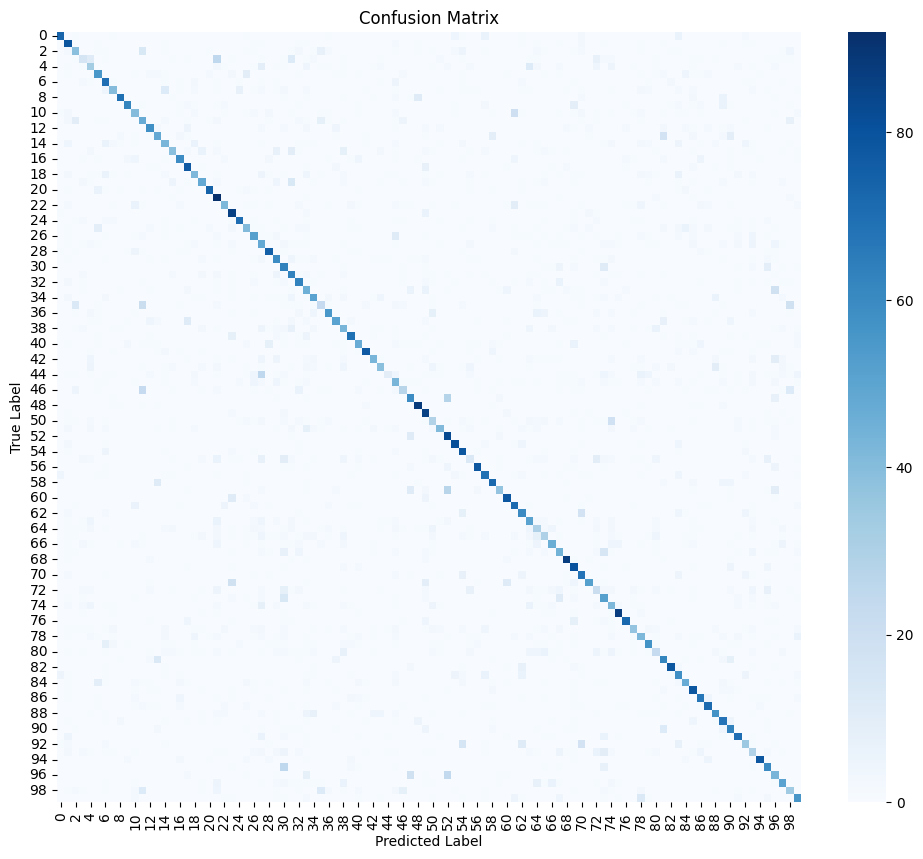

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues')  
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [45]:
styled_table = f1_table.style.background_gradient(cmap='YlGnBu')\
                                .format({'precision': "{:.2f}", 'recall': "{:.2f}", 'f1-score': "{:.2f}"})
styled_table


,precision,recall,f1-score,support
0,0.85,0.73,0.78,100.000000
1,0.52,0.79,0.63,100.000000
2,0.47,0.39,0.43,100.000000
3,0.31,0.16,0.21,100.000000
4,0.35,0.33,0.34,100.000000
5,0.57,0.55,0.56,100.000000
6,0.52,0.70,0.60,100.000000
7,0.63,0.40,0.49,100.000000
8,0.85,0.69,0.76,100.000000
9,0.84,0.62,0.71,100.000000
